In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters import SortedConv2D

In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y = SortedConv2D(filters=32,activation=tf.nn.relu, padding='SAME')(input_net)
#y = Add()([a,s])
'''y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = SortedConv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu, padding='SAME')(y)
#y = Add()([a,s])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) '''

y = layers.Flatten()(y)
y = layers.Dense(1000, activation=tf.nn.relu)(y)
output_net  = layers.Dense(100)(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d (SortedConv2D  (None, 32, 32, 32)       321       
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1000)              32769000  
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
Total params: 32,869,421
Trainable params: 32,869,421
Non-trainable params: 0
_________________________________________________

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


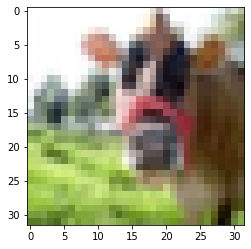

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])

In [5]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 100
epochs = 20
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
500/500 [==============================] - 9s 14ms/step - loss: 11.4709 - accuracy: 0.0191 - top-5-accuracy: 0.0710 - val_loss: 4.6745 - val_accuracy: 0.0250 - val_top-5-accuracy: 0.0889
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 4.5222 - accuracy: 0.0309 - top-5-accuracy: 0.1116 - val_loss: 4.5572 - val_accuracy: 0.0289 - val_top-5-accuracy: 0.1167
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 4.4107 - accuracy: 0.0362 - top-5-accuracy: 0.1300 - val_loss: 4.5532 - val_accuracy: 0.0278 - val_top-5-accuracy: 0.1184
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 4.3621 - accuracy: 0.0439 - top-5-accuracy: 0.1460 - val_loss: 4.5131 - val_accuracy: 0.0352 - val_top-5-accuracy: 0.1370
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 4.2700 - accuracy: 0.0520 - top-5-accuracy: 0.1748 - val_loss: 4.5501 - val_accuracy: 0.0366 - val_top-5-accuracy: 0.1613
Epoch 6/20
498

KeyboardInterrupt: 

In [ ]:
get_layer_output = K.function([model.input], model.layers[2].output)

n = 2

X = np.expand_dims(x_test[n], axis=0)
print(y_test[n], np.argmax(model.predict(X)))


layer_out = np.array(get_layer_output([X]))
print(layer_out.shape)
plt.figure(1)  

plt.imshow(np.sum(layer_out[0, :,:, :], axis=-1),  cmap='gray_r')   
plt.figure(2)  

plt.imshow(x_test[n],  cmap='gray_r')   

 